<a href="https://colab.research.google.com/github/SharaVigneswaran/Data-Science-Machine-Learning-Project/blob/ML-Project/Google_Code_Advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science & Machine Learning


---


*Google Group: Jeanne Salamin & Shara Vigneswaran*


This Colab notebook comprises models developed to predict the difficulty of French sentences using advanced large language models.

# Data Importation

In [12]:
import pandas as pd

In [13]:
# Training Data Dataframe
training_data_url = "https://github.com/SharaVigneswaran/Data-Science-Machine-Learning-Project/raw/main/training_data.csv"
df_training_data = pd.read_csv(training_data_url)
df_training_data

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...,...
4795,4795,"C'est pourquoi, il décida de remplacer les hab...",B2
4796,4796,Il avait une de ces pâleurs splendides qui don...,C1
4797,4797,"Et le premier samedi de chaque mois, venez ren...",A2
4798,4798,Les coûts liés à la journalisation n'étant pas...,C2


In [14]:
# Unlabelled Test Data Dataframe
unlabelled_test_data_url = "https://github.com/SharaVigneswaran/Data-Science-Machine-Learning-Project/raw/main/unlabelled_test_data.csv"
df_unlabelled_test_data = pd.read_csv(unlabelled_test_data_url)
df_unlabelled_test_data

,id,sentence
0,0,Nous dûmes nous excuser des propos que nous eû...
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,2,"Et, paradoxalement, boire froid n'est pas la b..."
3,3,"Ce n'est pas étonnant, car c'est une saison my..."
4,4,"Le corps de Golo lui-même, d'une essence aussi..."
...,...,...
1195,1195,C'est un phénomène qui trouve une accélération...
1196,1196,Je vais parler au serveur et voir si on peut d...
1197,1197,Il n'était pas comme tant de gens qui par pare...
1198,1198,Ils deviennent dangereux pour notre économie.


## Data Augmentation

The goal of this data augmentation is to enhance a dataset used for natural language processing (NLP) tasks by increasing its diversity. It achieves this by replacing words in each sentence with their synonyms, thereby generating variations of the original sentences. By doing so, the augmented dataset becomes more varied, capturing a broader range of language patterns and nuances.

In [15]:
import nltk
from nltk.corpus import wordnet
import random

# Ensure you have downloaded the necessary NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')

def get_synonyms(word):
    """Return a set of synonyms for the word."""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)  # Remove the original word to avoid redundancy
    return list(synonyms)

def synonym_replacement(sentence, n):
    """Replace up to n words in the sentence with their synonyms."""
    words = sentence.split()
    random.shuffle(words)
    new_words = words.copy()
    for word in words:
        synonyms = get_synonyms(word)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words[new_words.index(word)] = synonym
            n -= 1
            if n == 0:
                break
    return ' '.join(new_words)

def augment_dataset(dataframe, n=1):
    """Augment the dataset by replacing up to n words with synonyms in each sentence."""
    augmented_sentences = []
    for _, row in dataframe.iterrows():
        new_sentence = synonym_replacement(row['sentence'], n)
        augmented_sentences.append({'sentence': new_sentence, 'difficulty': row['difficulty']})
    return pd.DataFrame(augmented_sentences)


# Augment the dataset
augmented_df = augment_dataset(df_training_data, n=1)  # Change n to control the number of replacements per sentence
augmented_df = pd.concat([df_training_data, augmented_df]).reset_index(drop=True)
augmented_df

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,id,sentence,difficulty
0,0.0,Les coûts kilométriques réels peuvent diverger...,C1
1,1.0,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2.0,Le test de niveau en français est sur le site ...,A1
3,3.0,Est-ce que ton mari est aussi de Boston?,A1
4,4.0,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...,...
9595,NaN,diethylstilbesterol caractère très qui donna u...,B2
9596,NaN,qui donnent Midi. quelque une take de aux sple...,C1
9597,NaN,"lupus erythematosus chaque de rencontrer mois,...",A2
9598,NaN,"pertinents. à n'étant infinie, responsable sho...",C2


## Expanding columns


Expanding the dependent variable (X) by appending additional columns to the existing training data during model training.

In [16]:
import re

# Define a simple function to estimate syllable count based on vowel groups
def simple_syllable_count(text):
    count = 0
    vowels = "aeiouy"
    words = text.lower().split()
    for word in words:
        word_count = 0
        if word[0] in vowels:
            word_count += 1
        for i in range(1, len(word)):
            if word[i] in vowels and word[i - 1] not in vowels:
                word_count += 1
        if word.endswith('e'):
            word_count -= 1
        if word_count == 0:
            word_count += 1
        count += word_count
    return count

# Define function to calculate Type-Token Ratio
def type_token_ratio(text):
    words = text.split()
    if len(words) == 0:
        return 0
    else:
        return len(set(words)) / len(words)

# Recalculate the syllable count using the simple syllable estimation method
df_training_data['sentence_length'] = df_training_data['sentence'].apply(lambda x: len(x.split()))
df_training_data['type_token_ratio'] = df_training_data['sentence'].apply(type_token_ratio)
df_training_data['syllable_count'] = df_training_data['sentence'].apply(simple_syllable_count)
df_training_data['average_word_length'] = df_training_data['sentence'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)
df_training_data

,id,sentence,difficulty,sentence_length,type_token_ratio,syllable_count,average_word_length
0,0,Les coûts kilométriques réels peuvent diverger...,C1,38,0.763158,69,5.736842
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,12,1.000000,13,4.250000
2,2,Le test de niveau en français est sur le site ...,A1,13,0.923077,18,4.153846
3,3,Est-ce que ton mari est aussi de Boston?,A1,8,1.000000,11,4.125000
4,4,"Dans les écoles de commerce, dans les couloirs...",B1,34,0.823529,53,5.176471
...,...,...,...,...,...,...,...
4795,4795,"C'est pourquoi, il décida de remplacer les hab...",B2,26,1.000000,46,5.384615
4796,4796,Il avait une de ces pâleurs splendides qui don...,C1,21,0.952381,31,4.666667
4797,4797,"Et le premier samedi de chaque mois, venez ren...",A2,14,0.928571,22,4.785714
4798,4798,Les coûts liés à la journalisation n'étant pas...,C2,32,0.875000,56,6.093750


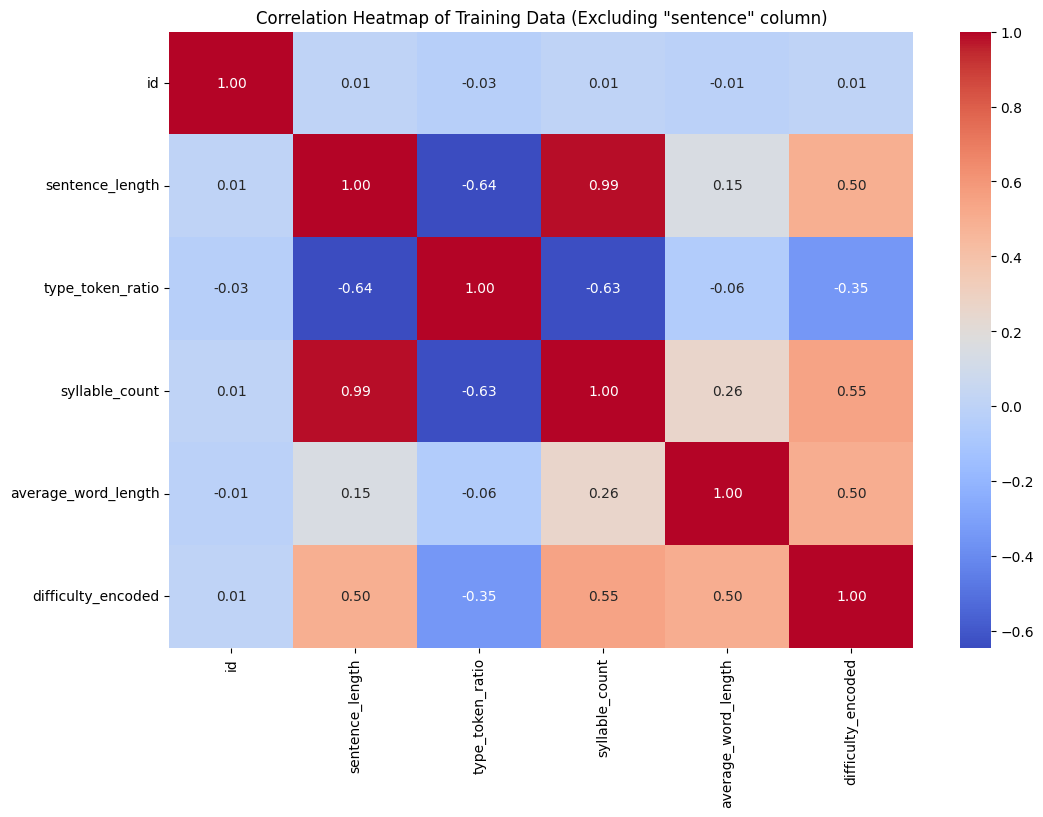

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding difficulty values
difficulty_encoding = {
    'A1': 1,
    'A2': 2,
    'B1': 3,
    'B2': 4,
    'C1': 5,
    'C2': 6
}

# Map difficulty values to numerical encoding
df_training_data['difficulty_encoded'] = df_training_data['difficulty'].map(difficulty_encoding)

# Drop the column named "sentence" before computing the correlation matrix
correlation_matrix = df_training_data.drop(columns=['sentence', 'difficulty']).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Training Data (Excluding "sentence" column)')
plt.show()


## Data Size Augmentation

In [18]:
# Augmented Size Training Data
new_training_data_url = "https://github.com/SharaVigneswaran/Data-Science-Machine-Learning-Project/raw/main/augmented_training_data_50.csv"
new_df_training_data = pd.read_csv(new_training_data_url)
new_df_training_data

,id,sentence,difficulty
0,0.0,Les coûts kilométriques réels peuvent diverger...,C1
1,1.0,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2.0,Le test de niveau en français est sur le site ...,A1
3,3.0,Est-ce que ton mari est aussi de Boston?,A1
4,4.0,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...,...
5095,NaN,Elle avait l'habitude de faire du bénévolat à ...,B1
5096,NaN,"Après avoir écouté la chanson, elle la chantai...",B1
5097,NaN,"En voyageant en voiture, ils s'arrêtaient touj...",B1
5098,NaN,Elle avait l'habitude de cuisiner des plats tr...,B1


# RoBERTa

In [8]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load data
training_data_url = "https://github.com/SharaVigneswaran/Data-Science-Machine-Learning-Project/raw/main/training_data.csv"
df_training_data = pd.read_csv(training_data_url)

# Label encoding
label_encoder = LabelEncoder()
df_training_data['encoded_labels'] = label_encoder.fit_transform(df_training_data['difficulty'])

# Tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenizing data
train_texts, val_texts, train_labels, val_labels = train_test_split(df_training_data['sentence'], df_training_data['encoded_labels'], test_size=0.1)
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# Dataset class
class FrenchTextDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings.input_ids)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Create dataset objects
train_dataset = FrenchTextDataset(train_encodings, train_labels.tolist())
val_dataset = FrenchTextDataset(val_encodings, val_labels.tolist())

# Load pre-trained RoBERTa model for classification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)  # Adjust learning rate

# Total number of training steps
total_steps = len(train_dataset) // 16 * 5  # Increase number of epochs

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
model.train()
for epoch in range(5):  # Increase to more epochs
    total_loss = 0
    for batch in DataLoader(train_dataset, batch_size=16, shuffle=True):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataset)}")

# Evaluation
model.eval()
val_loader = DataLoader(val_dataset, batch_size=32)
val_labels = []
val_preds = []
for batch in val_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    val_labels.extend(batch['labels'].cpu().numpy())
    val_preds.extend(predictions.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {accuracy}")

# Now, apply the model to the unlabeled test data for Kaggle submission
unlabelled_test_data_url = "https://github.com/SharaVigneswaran/Data-Science-Machine-Learning-Project/raw/main/unlabelled_test_data.csv"
df_unlabelled_test_data = pd.read_csv(unlabelled_test_data_url)

test_encodings = tokenizer(df_unlabelled_test_data['sentence'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = FrenchTextDataset(test_encodings)

model.eval()
test_loader = DataLoader(test_dataset, batch_size=16)
preds = []

for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    preds.extend(predictions.cpu().numpy())

# Decode predictions back to difficulty labels
decoded_predictions = label_encoder.inverse_transform(preds)

# Add predicted difficulty to the DataFrame
df_unlabelled_test_data['difficulty'] = decoded_predictions

# Save submission file
submission_file_path = "submission.csv"
df_unlabelled_test_data[['id', 'difficulty']].to_csv(submission_file_path, index=False)

# Optionally, if using Google Colab, use the following to download the file:
from google.colab import files
#files.download(submission_file_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-8-e62e21720666>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1, Loss: 0.0916299984410957
Epoch 2, Loss: 0.0768760718267273
Epoch 3, Loss: 0.06671228154941841
Epoch 4, Loss: 0.05882314792661755
Epoch 5, Loss: 0.05332540653783966
Validation Accuracy: 0.5


<ipython-input-8-e62e21720666>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calculate metrics for RoBERTa model
precision = precision_score(val_labels, val_preds, average='weighted')
recall = recall_score(val_labels, val_preds, average='weighted')
f1 = f1_score(val_labels, val_preds, average='weighted')
accuracy = accuracy_score(val_labels, val_preds)

print(f"RoBERTa Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

RoBERTa Metrics:
Precision: 0.5186
Recall: 0.5000
F1-score: 0.4979
Accuracy: 0.5000


# OpemAI Embeddings model ="gpt-3.5-turbo-instruct"

In [11]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.8 MB/s eta 0:00:00


In [12]:
from sklearn.model_selection import train_test_split

# Split your training data to create a validation set
train_df, val_df = train_test_split(df_training_data, test_size=0.2, random_state=42)

In [13]:
import openai

openai.api_key = 'This is secret'

# Function to generate predictions using OpenAI API
def generate_predictions(texts):
    predictions = []
    for text in texts:
        try:
            response = openai.Completion.create(
                model="gpt-3.5-turbo-instruct",
                prompt=f"Classify the text difficulty from A1 to C2: '{text}'. Provide a single label.",
                max_tokens=50
            )
            prediction = response.choices[0].text.strip()
            predictions.append(prediction)
        except Exception as e:
            print(f"An error occurred: {e}")
            predictions.append('Unknown')  # Use a placeholder for failed predictions
    return predictions

# Generate predictions for the validation set
val_df['predicted_difficulty'] = generate_predictions(val_df['sentence'])

An error occurred: 

You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

An error occurred: 

You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

An error occurred: 

You tried to ac

In [14]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(val_df['difficulty'], val_df['predicted_difficulty'])
print(f"Accuracy: {accuracy}")

#The output gave: Accuracy: 0.23125

Accuracy: 0.0


#OpenAI Embeddings model="text-embedding-3-large"

In [1]:
!pip install openai sklearn pandas

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
!pip install openai==0.28

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import openai

# Set your OpenAI API key
openai.api_key = 'This_is_secret'

# Function to fetch embeddings from OpenAI
def get_embeddings(texts, model="text-embedding-3-large"):
    embeddings = []
    for text in texts:
        response = openai.Embedding.create(
            input=text,
            model=model
        )
        embeddings.append(response['data'][0]['embedding'])
    return embeddings


# Generate embeddings for the training data
train_embeddings = get_embeddings(df_training_data['sentence'].tolist())

# Labels
y = df_training_data['difficulty']

# Train a classifier
X_train, X_test, y_train, y_test = train_test_split(train_embeddings, y, test_size=0.2, random_state=42)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

ServiceUnavailableError: The server is overloaded or not ready yet.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_true contains the true labels for the test set
y_true = y_test  # Replace this with the true labels

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# BERT (Multilingual) model= 'bert-base-multilingual-cased'

In [4]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load data
training_data_url = "https://github.com/SharaVigneswaran/Data-Science-Machine-Learning-Project/raw/main/training_data.csv"
df_training_data = pd.read_csv(training_data_url)

# Label encoding
label_encoder = LabelEncoder()
df_training_data['encoded_labels'] = label_encoder.fit_transform(df_training_data['difficulty'])

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Tokenizing data
train_texts, val_texts, train_labels, val_labels = train_test_split(df_training_data['sentence'], df_training_data['encoded_labels'], test_size=0.1)
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# Dataset class
class FrenchTextDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings.input_ids)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Create dataset objects
train_dataset = FrenchTextDataset(train_encodings, train_labels.tolist())
val_dataset = FrenchTextDataset(val_encodings, val_labels.tolist())

# Load pre-trained BERT model for classification
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(label_encoder.classes_))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
model.train()
for epoch in range(3):  # Number of epochs
    for batch in DataLoader(train_dataset, batch_size=16, shuffle=True):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Evaluation
model.eval()
val_loader = DataLoader(val_dataset, batch_size=16)
val_labels = []
val_preds = []
for batch in val_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    val_labels.extend(batch['labels'].cpu().numpy())
    val_preds.extend(predictions.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(val_labels, val_preds)
precision, recall, fscore, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted')

print(f"Validation Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {fscore}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-4-f7b80c177e8e>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1, Loss: 1.0418477058410645
Epoch 2, Loss: 0.8555447459220886
Epoch 3, Loss: 1.0495541095733643
Validation Accuracy: 0.5666666666666667
Precision: 0.5802138020227677
Recall: 0.5666666666666667
F1 Score: 0.5609868362376498


# CamemBERT, Check Out Our Most Accurate Model!


In [8]:
# Import packages
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import CamembertTokenizer, CamembertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import nltk
from nltk.corpus import wordnet
import random

In [10]:
# Label encoding
label_encoder = LabelEncoder()
augmented_df['encoded_labels'] = label_encoder.fit_transform(augmented_df['difficulty'])

# Tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# Data preparation function
def prepare_data(texts, labels):
    # Ensure texts is a list of strings
    text_list = texts.tolist()  # Convert Series to list
    text_list = [str(text) for text in text_list]  # Ensure each element is a string
    encodings = tokenizer(text_list, truncation=True, padding=True, max_length=128, return_tensors="pt")
    dataset = FrenchTextDataset(encodings, labels)
    return dataset

class FrenchTextDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}  # Use clone().detach()
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Split data and prepare datasets
train_texts, val_texts, train_labels, val_labels = train_test_split(augmented_df['sentence'], augmented_df['encoded_labels'], test_size=0.1, random_state=42)
train_dataset = prepare_data(train_texts, train_labels.tolist())
val_dataset = prepare_data(val_texts, val_labels.tolist())

# Model
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=len(label_encoder.classes_))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer and scheduler setup
optimizer = AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) * 5  # Assuming 5 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
model.train()
for epoch in range(5):
    for batch in DataLoader(train_dataset, batch_size=16, shuffle=True):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluation
model.eval()
val_loader = DataLoader(val_dataset, batch_size=16)
val_preds, val_labels = [], []
for batch in val_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    val_preds.extend(predictions.cpu().numpy())
    val_labels.extend(batch['labels'].cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(val_labels, val_preds)
precision, recall, fscore, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted')

print(f'Validation Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {fscore}')


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 1.3480037450790405
Epoch 2, Loss: 0.808245837688446
Epoch 3, Loss: 1.1661598682403564
Epoch 4, Loss: 0.6123865246772766
Epoch 5, Loss: 0.8842939138412476
Validation Accuracy: 0.575
Precision: 0.6041593300610317
Recall: 0.575
F1 Score: 0.5808552911821133


## Confusion Matrix of the Most Accurate Model (CamemBert)

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import CamembertTokenizer, CamembertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Evaluation
model.eval()
val_loader = DataLoader(val_dataset, batch_size=16)
val_preds, val_labels = [], []
for batch in val_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    val_preds.extend(predictions.cpu().numpy())
    val_labels.extend(batch['labels'].cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(val_labels, val_preds)
print("Confusion Matrix:\n", cm)

# Calculate metrics
accuracy = accuracy_score(val_labels, val_preds)
precision, recall, fscore, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted')

print(f'Validation Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {fscore}')

In [ ]:
pip install matplotlib seaborn


In [ ]:
mport matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the confusion matrix
confusion_mtx = np.array([
    [143, 6, 0, 0, 0, 0],
    [32, 142, 6, 0, 0, 0],
    [9, 50, 103, 1, 0, 0],
    [2, 0, 18, 137, 9, 5],
    [1, 1, 3, 37, 100, 12],
    [0, 1, 2, 12, 16, 112]
])

# Labels for your confusion matrix (adjust as needed)
labels=['A1', 'A2', 'B1', 'B2', 'C1', 'C2']


plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# CamemBERT training on full dataset

In [20]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import CamembertTokenizer, CamembertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Label encoding
label_encoder = LabelEncoder()
df_training_data['encoded_labels'] = label_encoder.fit_transform(df_training_data['difficulty'])

# Tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# Data preparation function
def prepare_data(texts, labels):
    # Ensure texts is a list of strings
    text_list = texts.tolist()  # Convert Series to list
    text_list = [str(text) for text in text_list]  # Ensure each element is a string
    encodings = tokenizer(text_list, truncation=True, padding=True, max_length=128, return_tensors="pt")
    dataset = FrenchTextDataset(encodings, labels)
    return dataset

class FrenchTextDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}  # Use clone().detach()
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Prepare the full dataset
train_dataset = prepare_data(df_training_data['sentence'], df_training_data['encoded_labels'].tolist())

# Model
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=len(label_encoder.classes_))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer and scheduler setup
optimizer = AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) * 5  # Assuming 5 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
model.train()
for epoch in range(5):
    for batch in DataLoader(train_dataset, batch_size=16, shuffle=True):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluation
# If you have a separate validation set, use it for evaluation here.
# Otherwise, evaluation on the training set might not provide meaningful insights.

# Assuming you evaluate on the same training set for demonstration
model.eval()
train_loader = DataLoader(train_dataset, batch_size=16)
train_preds, train_labels = [], []
for batch in train_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    train_preds.extend(predictions.cpu().numpy())
    train_labels.extend(batch['labels'].cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(train_labels, train_preds)
precision, recall, fscore, _ = precision_recall_fscore_support(train_labels, train_preds, average='weighted')

print(f'Training Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {fscore}')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 1.2165641784667969
Epoch 2, Loss: 1.4147405624389648
Epoch 3, Loss: 0.5101816058158875
Epoch 4, Loss: 0.6684457659721375
Epoch 5, Loss: 0.5795787572860718
Training Accuracy: 0.915
Precision: 0.917073069800697
Recall: 0.915
F1 Score: 0.914681195152023


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Modeling on the full dataset leads to increased overfitting of our model. The following code is the same as above but in addition prints the validation losses and a graph illustrating the challenge of overfitting.

In [ ]:
#The same code as above but to show overefitting.

import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import CamembertTokenizer, CamembertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Label encoding
label_encoder = LabelEncoder()
df_training_data['encoded_labels'] = label_encoder.fit_transform(df_training_data['difficulty'])

# Tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# Data preparation function
def prepare_data(texts, labels):
    # Ensure texts is a list of strings
    text_list = texts.tolist()  # Convert Series to list
    text_list = [str(text) for text in text_list]  # Ensure each element is a string
    encodings = tokenizer(text_list, truncation=True, padding=True, max_length=128, return_tensors="pt")
    dataset = FrenchTextDataset(encodings, labels)
    return dataset

class FrenchTextDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}  # Use clone().detach()
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Split data and prepare datasets
train_texts, val_texts, train_labels, val_labels = train_test_split(df_training_data['sentence'], df_training_data['encoded_labels'], test_size=0.1, random_state=42)
train_dataset = prepare_data(train_texts, train_labels.tolist())
val_dataset = prepare_data(val_texts, val_labels.tolist())

# Model
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=len(label_encoder.classes_))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer and scheduler setup
optimizer = AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) * 5  # Assuming 5 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
train_losses = []
val_losses = []
model.train()
for epoch in range(5):
    total_train_loss = 0
    for batch in DataLoader(train_dataset, batch_size=16, shuffle=True):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    avg_train_loss = total_train_loss / len(DataLoader(train_dataset, batch_size=16, shuffle=True))
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    for batch in DataLoader(val_dataset, batch_size=16):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(DataLoader(val_dataset, batch_size=16))
    val_losses.append(avg_val_loss)
    model.train()

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

# Plotting the losses
plt.plot(range(1, 6), train_losses, label='Training Loss')
plt.plot(range(1, 6), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training Loss: 1.3806303724094673, Validation Loss: 1.0738247215747834
Epoch 2, Training Loss: 1.0107852847487837, Validation Loss: 0.9735238015651703
Epoch 3, Training Loss: 0.9289118118860104, Validation Loss: 1.1490666886170706


# FlauBERT

In [ ]:
pip install sacremoses

In [ ]:
# Training Data Dataframe
training_data_url = "https://github.com/SharaVigneswaran/Data-Science-Machine-Learning-Project/raw/main/training_data.csv"
df_training_data = pd.read_csv(training_data_url)
df_training_data

In [ ]:
import nltk
from nltk.corpus import wordnet
import pandas as pd
import random

# Ensure you have downloaded the necessary NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')

def get_synonyms(word):
    """Return a set of synonyms for the word."""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)  # Remove the original word to avoid redundancy
    return list(synonyms)

def synonym_replacement(sentence, n):
    """Replace up to n words in the sentence with their synonyms."""
    words = sentence.split()
    random.shuffle(words)
    new_words = words.copy()
    for word in words:
        synonyms = get_synonyms(word)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words[new_words.index(word)] = synonym
            n -= 1
            if n == 0:
                break
    return ' '.join(new_words)

def augment_dataset(dataframe, n=1):
    """Augment the dataset by replacing up to n words with synonyms in each sentence."""
    augmented_sentences = []
    for _, row in dataframe.iterrows():
        new_sentence = synonym_replacement(row['sentence'], n)
        augmented_sentences.append({'sentence': new_sentence, 'difficulty': row['difficulty']})
    return pd.DataFrame(augmented_sentences)


# Augment the dataset
augmented_df = augment_dataset(df_training_data, n=1)  # Change n to control the number of replacements per sentence

# Optionally, combine the original and augmented data, or save the augmented data
df_training_data = pd.concat([df_training_data, augmented_df]).reset_index(drop=True)
df_training_data

In [ ]:
from transformers import FlaubertTokenizer, FlaubertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd

# Label encoding
label_encoder = LabelEncoder()
augmented_df['encoded_labels'] = label_encoder.fit_transform(augmented_df['difficulty'])

# Tokenizer
tokenizer = FlaubertTokenizer.from_pretrained('flaubert/flaubert_base_cased')

# Data preparation function
def prepare_data(texts, labels):
    text_list = texts.tolist()
    text_list = [str(text) for text in text_list]
    encodings = tokenizer(text_list, truncation=True, padding=True, max_length=128, return_tensors="pt")
    dataset = FrenchTextDataset(encodings, labels)
    return dataset

class FrenchTextDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Split data and prepare datasets
train_texts, val_texts, train_labels, val_labels = train_test_split(augmented_df['sentence'], augmented_df['encoded_labels'], test_size=0.1, random_state=42)
train_dataset = prepare_data(train_texts, train_labels.tolist())
val_dataset = prepare_data(val_texts, val_labels.tolist())

# Model
model = FlaubertForSequenceClassification.from_pretrained('flaubert/flaubert_base_cased', num_labels=len(label_encoder.classes_))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer and scheduler setup
optimizer = AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) * 5
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
model.train()
for epoch in range(5):
    for batch in DataLoader(train_dataset, batch_size=16, shuffle=True):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluation
model.eval()
val_loader = DataLoader(val_dataset, batch_size=16)
val_preds, val_labels = [], []
for batch in val_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    val_preds.extend(predictions.cpu().numpy())
    val_labels.extend(batch['labels'].cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(val_labels, val_preds)
precision, recall, fscore, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted')

print(f'Validation Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {fscore}')

In [ ]:
# Load unlabeled test data
unlabeled_data_url = "https://github.com/SharaVigneswaran/Data-Science-Machine-Learning-Project/raw/main/unlabelled_test_data.csv"
df_unlabeled_test_data = pd.read_csv(unlabeled_data_url)

# Prepare unlabeled data
unlabeled_texts = df_unlabeled_test_data['sentence']
unlabeled_encodings = tokenizer(unlabeled_texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
unlabeled_dataset = FrenchTextDataset(unlabeled_encodings)

# DataLoader for the unlabeled dataset
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=16)

# Make predictions
model.eval()
all_predictions = []
for batch in unlabeled_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    all_predictions.extend(predictions.cpu().numpy())

# Map predictions back to label names using label encoder
predicted_labels = label_encoder.inverse_transform(all_predictions)

# Add predictions to DataFrame and save to CSV for submission
df_unlabeled_test_data['difficulty'] = predicted_labels
submission_file_path = "submission.csv"
df_unlabeled_test_data[['id', 'difficulty']].to_csv(submission_file_path, index=False)

# Optionally, if using Google Colab, use the following to download the file:
from google.colab import files
files.download(submission_file_path)

# Trying CamemBert with Augmented Dataset of 5,100 rows and checking for overfitting at the same time.

In [ ]:
# Augmented Training Data
new_training_data_url = "https://github.com/SharaVigneswaran/Data-Science-Machine-Learning-Project/raw/main/augmented_training_data_50.csv"
new_df_training_data = pd.read_csv(new_training_data_url)
new_df_training_data

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import CamembertTokenizer, CamembertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Augmented Training Data
new_training_data_url = "https://github.com/SharaVigneswaran/Data-Science-Machine-Learning-Project/raw/main/augmented_training_data_50.csv"
new_df_training_data = pd.read_csv(new_training_data_url)

# Label encoding
label_encoder = LabelEncoder()
new_df_training_data['encoded_labels'] = label_encoder.fit_transform(new_df_training_data['difficulty'])

# Tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# Data preparation function
def prepare_data(texts, labels):
    text_list = texts.tolist()
    text_list = [str(text) for text in text_list]
    encodings = tokenizer(text_list, truncation=True, padding=True, max_length=128, return_tensors="pt")
    dataset = FrenchTextDataset(encodings, labels)
    return dataset

class FrenchTextDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Split data and prepare datasets
train_texts, val_texts, train_labels, val_labels = train_test_split(new_df_training_data['sentence'], new_df_training_data['encoded_labels'], test_size=0.1, random_state=42)
train_dataset = prepare_data(train_texts, train_labels.tolist())
val_dataset = prepare_data(val_texts, val_labels.tolist())

# Model
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=len(label_encoder.classes_))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer and scheduler setup
optimizer = AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) * 8
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
training_losses = []
validation_losses = []
for epoch in range(8):
    epoch_train_loss = 0
    for batch in DataLoader(train_dataset, batch_size=8, shuffle=True):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    avg_train_loss = epoch_train_loss / len(train_dataset)
    training_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_losses = []
    for batch in DataLoader(val_dataset, batch_size=8):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        val_losses.append(loss.item())
    avg_val_loss = sum(val_losses) / len(val_losses)
    validation_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

# Plotting Training and Validation Losses
epochs = range(1, len(training_losses) + 1)
plt.plot(epochs, training_losses, 'b', label='Training loss')
plt.plot(epochs, validation_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation
model.eval()
val_loader = DataLoader(val_dataset, batch_size=8)
val_preds, val_labels = [], []
for batch in val_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    val_preds.extend(predictions.cpu().numpy())
    val_labels.extend(batch['labels'].cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(val_labels, val_preds)
precision, recall, fscore, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted')

print(f'Validation Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {fscore}')
